In [ ]:
import matplotlib
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

User input cell

In [ ]:
1#take user input for mass
m1= float(input("Enter mass m1: "))
m2=float(input("Enter mass m2: "))
#take user input for x1,x2,v1,v2
x1_input= input(("Enter initial coordinates of x1 as two space seperated values: "))
x10= [float(i) for i in  x1_input.split()]
x2_input= input(("Enter initial coordinates of x2 as two space seperated values: "))
x20= [float(i) for i in  x2_input.split()]
v1_input= input(("Enter initial coordinates of v1 as two space seperated values: "))
v10= [float(i) for i in  v1_input.split()]
v2_input= input(("Enter initial coordinates of v2 as two space seperated values: "))
v20= [float(i) for i in  v2_input.split()]
#take user input for Time of prediction of position
t_pred=float(input("Enter time of prediction of position: "))
G = 1  #gravitational constant

Enter mass m1: 1.0
Enter mass m2: 1.0
Enter initial coordinates of x1 as two space seperated values: -1.0 0.0
Enter initial coordinates of x2 as two space seperated values: 1.0 0.0
Enter initial coordinates of v1 as two space seperated values: 0.0 -0.5
Enter initial coordinates of v2 as two space seperated values: 0.0 0.5
Enter time of prediction of position: 0.5


Fully connected neural network model to use for PINN

In [ ]:
class FCN(nn.Module):
    '''
    N_input= no. of input nueron i.e. 1 (time)
    N_output= no. of output nueron i.e. 4 (x1[0],x1[1],x2[0],x2[1])
    N_hidden= no. nuerons in each hidden layer
    N_layers= no. of hidden layers
    '''
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        super().__init__()
        activation=nn.Tanh   #using tanh activation function
        self.fcs = nn.Sequential(
            nn.Linear(N_input, N_hidden),   # initial linear layer mapping from input size to hidden size
            activation())

        fch_layers = []
        for _ in range(N_layers-1):         # N_layers-1 hidden layers added after first hidden layer defined earlier
            fch_layers.append(nn.Linear(N_hidden, N_hidden))
            fch_layers.append(activation())
        self.fch = nn.Sequential(*fch_layers)

        self.fce= nn.Linear(N_hidden,N_output)  # linear layer mapping from hidden size to output size.
    def forward(self,x):
        x=self.fcs(x)
        x=self.fch(x)
        x=self.fce(x)
        return x  # data x passes through all the layers and returns output.

Training the model over training dataset (implemented ode loss)

In [ ]:
torch.manual_seed(123)
pinn=FCN(1,4,256,30)
#define initial point for initial condition(IC) loss
t_initial=torch.tensor(0.).view(-1,1).requires_grad_(True)
#define training points for ODE loss
t_train=torch.linspace(0,1,500).view(-1,1).requires_grad_(True)

#scaling factors
max_pos = max(max(abs(x) for x in x10 + x20), 1.0)
max_vel = max(max(abs(v) for v in v10 + v20), 1.0)

x10_scaled = [x/max_pos for x in x10]
x20_scaled = [x/ max_pos for x in x20]
v10_scaled = [v/ max_vel for v in v10]
v20_scaled = [v/ max_vel for v in v20]

ux_ic=torch.tensor([x10_scaled[0],x10_scaled[1],x20_scaled[0],x20_scaled[1]],dtype=torch.float32) #transforming given initial condition to predicted initial condition form
uv_ic=torch.tensor([v10_scaled[0],v10_scaled[1],v20_scaled[0],v20_scaled[1]],dtype=torch.float32)

#training the PINN first only on ic loss
optimiser=torch.optim.Adam(pinn.parameters(),lr=1e-4) #using adam optimiser with learning rate lr
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1000, gamma=0.5)
for i in range(2501):
    optimiser.zero_grad()  #clears old gradients from the last step before starting a new backward pass

    #computing the IC loss
    u= pinn(t_initial)
    loss_ic_x1= torch.mean((u[0, 0:2] - ux_ic[0:2])**2)
    loss_ic_x2= torch.mean((u[0, 2:4] - ux_ic[2:4])**2)

    v1 = []
    for j in range(2):
      v1_j = torch.autograd.grad(u[0, j], t_initial, torch.tensor(1.0, device=t_initial.device), create_graph=True)[0]* (max_pos/max_vel)
      v1.append(v1_j)
    v1 = torch.cat(v1, dim=-1)
    v2 = []
    for j in range(2):
      v2_j = torch.autograd.grad(u[0, j+2], t_initial, torch.tensor(1.0, device=t_initial.device), create_graph=True)[0]* (max_pos/max_vel)
      v2.append(v2_j)
    v2 = torch.cat(v2, dim=-1)
    loss_ic_v1= torch.mean((v1 - uv_ic[0:2])**2)
    loss_ic_v2= torch.mean((v2 - uv_ic[2:4])**2)
    loss_ic_total= (loss_ic_x1+loss_ic_x2)+100*(loss_ic_v1+loss_ic_v2)

    loss_ic_total.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), 1.0)  # Gradient clip
    optimiser.step()
    scheduler.step()

    if i % 500 == 0:
        print(f"Iteration {i} done loss_ic_total={loss_ic_total}")



Iteration 0 done loss_ic_total=25.979948043823242
Iteration 500 done loss_ic_total=0.15473248064517975
Iteration 1000 done loss_ic_total=0.05834696441888809
Iteration 1500 done loss_ic_total=0.0039411443285644054
Iteration 2000 done loss_ic_total=0.005008475389331579
Iteration 2500 done loss_ic_total=0.0009687335113994777


In [ ]:
#training the PINN
optimiser=torch.optim.Adam(pinn.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1000, gamma=0.5)
for i in range(15501):
    optimiser.zero_grad()  #clears old gradients from the last step before starting a new backward pass

    #computing the IC loss
    u= pinn(t_initial)
    loss_ic_x1= torch.mean((u[0, 0:2] - ux_ic[0:2])**2)
    loss_ic_x2= torch.mean((u[0, 2:4] - ux_ic[2:4])**2)

    v1 = []
    for j in range(2):
      v1_j = torch.autograd.grad(u[0, j], t_initial, torch.tensor(1.0, device=t_initial.device), create_graph=True)[0]* (max_pos/max_vel)
      v1.append(v1_j)
    v1 = torch.cat(v1, dim=-1)
    v2 = []
    for j in range(2):
      v2_j = torch.autograd.grad(u[0, j+2], t_initial, torch.tensor(1.0, device=t_initial.device), create_graph=True)[0]* (max_pos/max_vel)
      v2.append(v2_j)
    v2 = torch.cat(v2, dim=-1)
    loss_ic_v1= torch.mean((v1 - uv_ic[0:2])**2)
    loss_ic_v2= torch.mean((v2 - uv_ic[2:4])**2)
    loss_ic_total= (loss_ic_x1+loss_ic_x2)+50*(loss_ic_v1+loss_ic_v2)

    #computing the ODE loss
    u=pinn(t_train)
    x1=u[:,0:2]*max_pos
    x2=u[:,2:4]*max_pos
    v1=torch.autograd.grad(u[:,0:2],t_train,torch.ones_like(u[:,0:2]),create_graph=True)[0]* (max_pos/max_vel)
    v2=torch.autograd.grad(u[:,2:4],t_train,torch.ones_like(u[:,2:4]),create_graph=True)[0]* (max_pos/max_vel)
    a1=torch.autograd.grad(v1,t_train,torch.ones_like(v1),create_graph=True)[0]* (max_pos/max_vel**2)
    a2=torch.autograd.grad(v2,t_train,torch.ones_like(v2),create_graph=True)[0]* (max_pos/max_vel**2)
    r_cube = torch.norm(x1 - x2, dim=1, keepdim=True)**3+ 1e-8
    loss_ode_m2=torch.mean((a2[:, 0:2] - (x1 - x2)*m1*G/r_cube)**2)
    loss_ode_m1=torch.mean((a1[:, 0:2] - (x2 - x1)*m2*G/r_cube)**2)
    loss_ode_total= (loss_ode_m1+loss_ode_m2)

    if i<=1000:
        lambda1 = 1e4
        lambda2 = 1.0
    elif i<=2000:
        lambda1 = 1e3
        lambda2 = 1.0
    elif i<=3000:
        lambda1 = 1e1
        lambda2 = 1.0
    else :
        lambda1 = 1.0
        lambda2 = 1.0

    loss_total=lambda1*loss_ic_total+lambda2*loss_ode_total
    loss_total.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), 1.0)  # Gradient clip
    optimiser.step()
    scheduler.step()

    if i % 500 == 0:
        print(f"Iteration {i} done loss_ic_total={loss_ic_total} loss_ode_total={loss_ode_total} ")

Iteration 0 done loss_ic_total=0.0005792340962216258 loss_ode_total=0.7905858159065247 
Iteration 500 done loss_ic_total=0.0697765201330185 loss_ode_total=9.63272476196289 
Iteration 1000 done loss_ic_total=0.07499803602695465 loss_ode_total=11.935755729675293 
Iteration 1500 done loss_ic_total=0.032216500490903854 loss_ode_total=1.8134548664093018 
Iteration 2000 done loss_ic_total=0.005375828128308058 loss_ode_total=1.1511189937591553 
Iteration 2500 done loss_ic_total=0.00602522399276495 loss_ode_total=0.02897976152598858 
Iteration 3000 done loss_ic_total=0.004372033290565014 loss_ode_total=0.024363284930586815 
Iteration 3500 done loss_ic_total=0.001224070554599166 loss_ode_total=0.01434871181845665 
Iteration 4000 done loss_ic_total=0.0012335698120296001 loss_ode_total=0.014232773333787918 
Iteration 4500 done loss_ic_total=0.0011480869725346565 loss_ode_total=0.0142092015594244 
Iteration 5000 done loss_ic_total=0.0011485788272693753 loss_ode_total=0.014199387282133102 
Iteratio

- Using ode solver to generate ground truth values
- Running the model on testing dataset and calulating mean ode residual.

In [ ]:
#using ode solver to calculate ground truth values
def two_body_equations(y,t,m1,m2):
    '''
    x1,x2,v1,v2 are state variables
    t(float):time
    m1,m2(float):mass of bodies
    it returns array: derivatives of state variables
    '''
    r1=y[0:2]
    v1=y[2:4]
    r2=y[4:6]
    v2=y[6:8]
    r=np.linalg.norm(r2-r1) #distance between bodies
    a1=G*m2*(r2-r1)/r**3  #acceleration of bodies
    a2=G*m1*(r1-r2)/r**3
    #return the derivatives
    return np.concatenate((v1,a1,v2,a2))
initial_state=np.array([x10[0],x10[1],v10[0],v10[1],x20[0],x20[1],v20[0],v20[1]])

#testing time data  for the ode
t_test=np.linspace(0,1,300)
#solving the ode
solution=odeint(two_body_equations,initial_state,t_test,args=(m1,m2))
#The solution array contains the state variables at each time point
x_gt = solution[:, [0, 1, 4, 5]]

t_test_tensor = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).view(-1, 1)
x_pred=pinn(t_test_tensor).detach().numpy()*max_pos


#calculating mean ode residual for testing points
u=pinn(t_test_tensor)
v1=torch.autograd.grad(u[:,0:2],t_test_tensor,torch.ones_like(u[:,0:2]),create_graph=True)[0]
v2=torch.autograd.grad(u[:,2:4],t_test_tensor,torch.ones_like(u[:,2:4]),create_graph=True)[0]
a1=torch.autograd.grad(v1,t_test_tensor,torch.ones_like(v1),create_graph=True)[0]
a2=torch.autograd.grad(v2,t_test_tensor,torch.ones_like(v2),create_graph=True)[0]
r_cube = torch.norm(u[:, 0:2] - u[:, 2:4], dim=1, keepdim=True)**3 + 1e-8
loss_ode_m2=torch.sum((a2[:, 0:2] - (u[:, 0:2] - u[:,2:4])*m1*G/r_cube)**2, dim=1, keepdim=True)
loss_ode_m1=torch.sum((a1[:, 0:2] - (u[:, 2:4] - u[:,0:2])*m2*G/r_cube)**2, dim=1, keepdim=True)
mean_loss_ode_total= torch.mean(loss_ode_m1+loss_ode_m2)
print(f"Mean ODE residual across test cases= {mean_loss_ode_total}")

Mean ODE residual across test cases= 0.028135821223258972


Calculating MAE

In [ ]:
#calculating mae of predicted trajectory vs ground truth
mae = np.mean(np.abs(x_pred - x_gt))
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Mean Absolute Error (MAE): 0.036467


Plotting the trajectories

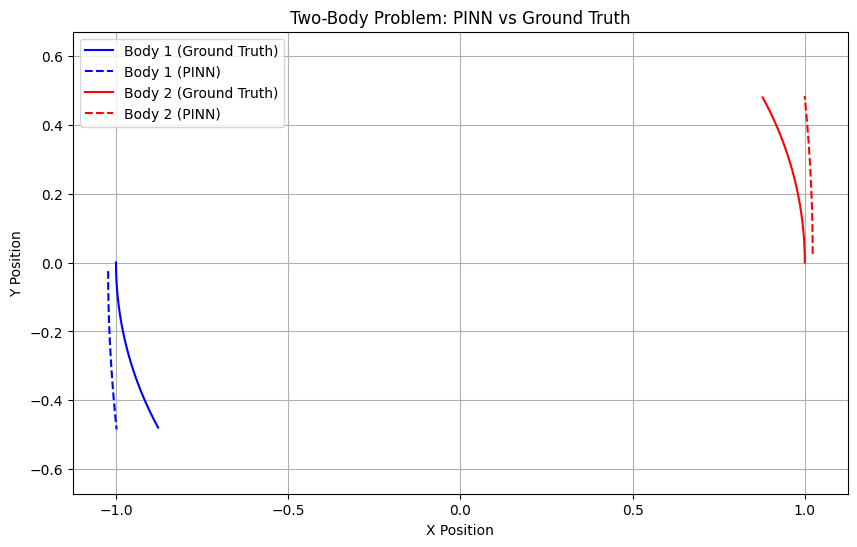

In [ ]:
#plotting the trajectories
plt.figure(figsize=(10, 6))
plt.plot(x_gt[:, 0], x_gt[:, 1], 'b-', label='Body 1 (Ground Truth)')
plt.plot(x_pred[:, 0], x_pred[:, 1], 'b--', label='Body 1 (PINN)')
plt.plot(x_gt[:, 2], x_gt[:, 3], 'r-', label='Body 2 (Ground Truth)')
plt.plot(x_pred[:, 2], x_pred[:, 3], 'r--', label='Body 2 (PINN)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Two-Body Problem: PINN vs Ground Truth')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig('two_body_trajectories.png')
plt.show()

Predicting position of planets at given user input time

In [ ]:
#predicted x1 and x2 at user input time t_pred
t_pred_tensor= torch.tensor([[t_pred]], dtype=torch.float32)
x_t_pred= pinn(t_pred_tensor).detach().cpu().numpy()*max_pos
x1= [x_t_pred[0, 0], x_t_pred[0, 1]]
x2= [x_t_pred[0, 2], x_t_pred[0, 3]]
print(f"Predicted position of body 1 (x1) at time {t_pred} = ({x1[0]:.6f},{x1[1]:.6f})")
print(f"Predicted position of body 2 (x2) at time {t_pred} = ({x2[0]:.6f},{x2[1]:.6f})")
solution2=odeint(two_body_equations,initial_state,[0,t_pred],args=(m1,m2))
x_gt2 = solution2[:, [0, 1, 4, 5]]
x12= [x_gt2[1,0], x_gt2[1,1]]
x22= [x_gt2[1,2], x_gt2[1,3]]
print(f"Actual position of body 1 (x1) at time {t_pred} = ({x12[0]:.6f},{x12[1]:.6f})")
print(f"Actual position of body 2 (x2) at time {t_pred} = ({x22[0]:.6f},{x22[1]:.6f})")

Predicted position of body 1 (x1) at time 0.5 = (-1.015807,-0.266432)
Predicted position of body 2 (x2) at time 0.5 = (1.016168,0.266070)
Actual position of body 1 (x1) at time 0.5 = (-0.968912,-0.247404)
Actual position of body 2 (x2) at time 0.5 = (0.968912,0.247404)
